#### ![](./seq2seq.png)

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
import math
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import numpy.typing as npt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### ![](./word-encoding.png)

In [2]:
SOS_token: int = 0
EOS_token: int = 1

class Lang:
    """Language vocabulary class for word-to-index mapping."""
    
    def __init__(self, name: str) -> None:
        self.name: str = name
        self.word2index: Dict[str, int] = {}
        self.word2count: Dict[str, int] = {}
        self.index2word: Dict[int, str] = {0: "SOS", 1: "EOS"}
        self.n_words: int = 2  # Count SOS and EOS
    
    def addSentence(self, sentence: str) -> None:
        """Add all words in a sentence to the vocabulary."""
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word: str) -> None:
        """Add a word to the vocabulary."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


def unicodeToAscii(s: str) -> str:
    """
    Turn a Unicode string to plain ASCII.
    Thanks to https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [3]:
def normalizeString(s: str) -> str:
    """Lowercase, trim, and remove non-letter characters."""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [4]:
def readLangs(lang1: str, lang2: str, reverse: bool = False) -> Tuple[Lang, Lang, List[List[str]]]:
    """Read language pairs from file."""
    print("Reading lines...")
    
    # Read the file and split into lines
    lines: List[str] = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs: List[List[str]] = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang: Lang = Lang(lang2)
        output_lang: Lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH: int = 10

eng_prefixes: Tuple[str, ...] = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p: List[str]) -> bool:
    """Check if a pair meets filtering criteria."""
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs: List[List[str]]) -> List[List[str]]:
    """Filter pairs based on length and prefix criteria."""
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1: str, lang2: str, reverse: bool = False) -> Tuple[Lang, Lang, List[List[str]]]:
    """Prepare data by reading, filtering, and building vocabulary."""
    input_lang: Lang
    output_lang: Lang
    pairs: List[List[str]]
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang: Lang
output_lang: Lang
pairs: List[List[str]]
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['nous sommes sideres', 'we re stunned']


## The Seq2Seq Model

#### ![](./seq2seq_1.png)

## The Encoder

#### ![](./encoder-network.png)

In [7]:
class EncoderRNN(nn.Module):
    """Encoder RNN with embedding and GRU."""
    
    def __init__(self, input_size: int, hidden_size: int, dropout_p: float = 0.1) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size: int = hidden_size
        
        self.embedding: nn.Embedding = nn.Embedding(input_size, hidden_size)
        self.gru: nn.GRU = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)
    
    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))
        output: torch.Tensor
        hidden: torch.Tensor
        output, hidden = self.gru(embedded)
        return output, hidden

## The Decoder

#### ![](./decoder-network.png)

In [8]:
class DecoderRNN(nn.Module):
    """Basic decoder RNN without attention."""
    
    def __init__(self, hidden_size: int, output_size: int) -> None:
        super(DecoderRNN, self).__init__()
        self.embedding: nn.Embedding = nn.Embedding(output_size, hidden_size)
        self.gru: nn.GRU = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
    
    def forward(
        self, 
        encoder_outputs: torch.Tensor, 
        encoder_hidden: torch.Tensor, 
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, None]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        
        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        return decoder_outputs_cat, decoder_hidden, None
    
    def forward_step(self, input: torch.Tensor, hidden: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        output: torch.Tensor = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

## Attention Decoder

#### ![](./attention-decoder-network.png)

In [9]:
class BahdanauAttention(nn.Module):
    """Bahdanau attention mechanism."""
    
    def __init__(self, hidden_size: int) -> None:
        super(BahdanauAttention, self).__init__()
        self.Wa: nn.Linear = nn.Linear(hidden_size, hidden_size)
        self.Ua: nn.Linear = nn.Linear(hidden_size, hidden_size)
        self.Va: nn.Linear = nn.Linear(hidden_size, 1)
    
    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        scores: torch.Tensor = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        
        weights: torch.Tensor = F.softmax(scores, dim=-1)
        context: torch.Tensor = torch.bmm(weights, keys)
        
        return context, weights


class AttnDecoderRNN(nn.Module):
    """Decoder RNN with Bahdanau attention."""
    
    def __init__(self, hidden_size: int, output_size: int, dropout_p: float = 0.1) -> None:
        super(AttnDecoderRNN, self).__init__()
        self.embedding: nn.Embedding = nn.Embedding(output_size, hidden_size)
        self.attention: BahdanauAttention = BahdanauAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)
    
    def forward(
        self, 
        encoder_outputs: torch.Tensor, 
        encoder_hidden: torch.Tensor, 
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []
        
        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)
            
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)
        
        return decoder_outputs_cat, decoder_hidden, attentions_cat
    
    def forward_step(
        self, 
        input: torch.Tensor, 
        hidden: torch.Tensor, 
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))
        
        query: torch.Tensor = hidden.permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)
        
        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        
        return output, hidden, attn_weights

In [10]:
def indexesFromSentence(lang: Lang, sentence: str) -> List[int]:
    """Convert sentence to list of word indices."""
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang: Lang, sentence: str) -> torch.Tensor:
    """Convert sentence to tensor."""
    indexes: List[int] = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def tensorsFromPair(pair: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
    """Convert a pair of sentences to tensors."""
    input_tensor: torch.Tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor: torch.Tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def get_dataloader(batch_size: int) -> Tuple[Lang, Lang, DataLoader]:
    """Create DataLoader for training."""
    input_lang_local: Lang
    output_lang_local: Lang
    pairs_local: List[List[str]]
    input_lang_local, output_lang_local, pairs_local = prepareData('eng', 'fra', True)
    
    n: int = len(pairs_local)
    input_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    
    for idx, (inp, tgt) in enumerate(pairs_local):
        inp_ids: List[int] = indexesFromSentence(input_lang_local, inp)
        tgt_ids: List[int] = indexesFromSentence(output_lang_local, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids
    
    train_data: TensorDataset = TensorDataset(
        torch.LongTensor(input_ids).to(device),
        torch.LongTensor(target_ids).to(device)
    )
    
    train_sampler: RandomSampler = RandomSampler(train_data)
    train_dataloader: DataLoader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang_local, output_lang_local, train_dataloader

In [11]:
def train_epoch(
    dataloader: DataLoader, 
    encoder: EncoderRNN, 
    decoder: nn.Module, 
    encoder_optimizer: optim.Optimizer,
    decoder_optimizer: optim.Optimizer, 
    criterion: nn.Module
) -> float:
    """Train for one epoch."""
    total_loss: float = 0.0
    for data in dataloader:
        input_tensor: torch.Tensor
        target_tensor: torch.Tensor
        input_tensor, target_tensor = data
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        encoder_outputs: torch.Tensor
        encoder_hidden: torch.Tensor
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs: torch.Tensor
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        
        loss: torch.Tensor = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [12]:
def asMinutes(s: float) -> str:
    """Convert seconds to minutes and seconds string."""
    m: int = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float) -> str:
    """Calculate elapsed and remaining time."""
    now: float = time.time()
    s: float = now - since
    es: float = s / percent
    rs: float = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def train(
    train_dataloader: DataLoader, 
    encoder: EncoderRNN, 
    decoder: nn.Module, 
    n_epochs: int, 
    learning_rate: float = 0.001,
    print_every: int = 100, 
    plot_every: int = 100
) -> None:
    """Train the model."""
    start: float = time.time()
    plot_losses: List[float] = []
    print_loss_total: float = 0.0
    plot_loss_total: float = 0.0
    
    encoder_optimizer: optim.Adam = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer: optim.Adam = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion: nn.NLLLoss = nn.NLLLoss()
    
    for epoch in range(1, n_epochs + 1):
        loss: float = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if epoch % print_every == 0:
            print_loss_avg: float = print_loss_total / print_every
            print_loss_total = 0.0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
        
        if epoch % plot_every == 0:
            plot_loss_avg: float = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0.0
    
    showPlot(plot_losses)

In [14]:
def showPlot(points: List[float]) -> None:
    """Plot training loss."""
    plt.figure()
    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots()
    loc: ticker.MultipleLocator = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.close(fig)

In [15]:
def evaluate(
    encoder: EncoderRNN, 
    decoder: nn.Module, 
    sentence: str, 
    input_lang: Lang, 
    output_lang: Lang
) -> Tuple[List[str], torch.Tensor]:
    """Evaluate a single sentence."""
    with torch.no_grad():
        input_tensor: torch.Tensor = tensorFromSentence(input_lang, sentence)
        
        encoder_outputs: torch.Tensor
        encoder_hidden: torch.Tensor
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs: torch.Tensor
        decoder_attn: torch.Tensor
        decoder_outputs, _, decoder_attn = decoder(encoder_outputs, encoder_hidden)
        
        _: torch.Tensor
        topi: torch.Tensor
        _, topi = decoder_outputs.topk(1)
        decoded_ids: torch.Tensor = topi.squeeze()
        
        decoded_words: List[str] = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [16]:
def evaluateRandomly(encoder: EncoderRNN, decoder: nn.Module, n: int = 10) -> None:
    """Evaluate random examples."""
    for i in range(n):
        pair: List[str] = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words: List[str]
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence: str = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [17]:
# Training
hidden_size: int = 128
batch_size: int = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder: EncoderRNN = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder: AttnDecoderRNN = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
1m 48s (- 27m 8s) (5 6%) 1.5637
3m 33s (- 24m 56s) (10 12%) 0.7162
13m 12s (- 57m 12s) (15 18%) 0.3806
30m 52s (- 92m 38s) (20 25%) 0.2159
32m 51s (- 72m 16s) (25 31%) 0.1349
34m 39s (- 57m 45s) (30 37%) 0.0933
36m 29s (- 46m 54s) (35 43%) 0.0702
45m 16s (- 45m 16s) (40 50%) 0.0564
47m 3s (- 36m 35s) (45 56%) 0.0483
48m 50s (- 29m 18s) (50 62%) 0.0423
68m 48s (- 31m 16s) (55 68%) 0.0390
70m 33s (- 23m 31s) (60 75%) 0.0365
72m 19s (- 16m 41s) (65 81%) 0.0339
92m 28s (- 13m 12s) (70 87%) 0.0323
131m 33s (- 8m 46s) (75 93%) 0.0311
133m 57s (- 0m 0s) (80 100%) 0.0298


In [18]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> vous etes tres solitaire
= you re very lonely
< you re very lonely <EOS>

> c est un puissant sorcier
= he s a powerful sorcerer
< he s a powerful sorcerer <EOS>

> tu es ambitieux
= you re ambitious
< you re ambitious <EOS>

> je suis creve
= i am exhausted
< i am tired <EOS>

> je ne porte pas de chaussettes
= i m not wearing socks
< i m not wearing socks <EOS>

> je nourris le poisson rouge
= i m feeding the goldfish
< i m feeding the goldfish <EOS>

> je suis plus qu un ami
= i m more than a friend
< i m more than a friend <EOS>

> ils ont de la chance d etre vivants
= they re lucky to be alive
< they re lucky to be alive <EOS>

> tu es courtoise
= you re courteous
< you re courteous <EOS>

> vous etes ambitieuses
= you re ambitious
< you re ambitious <EOS>



input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


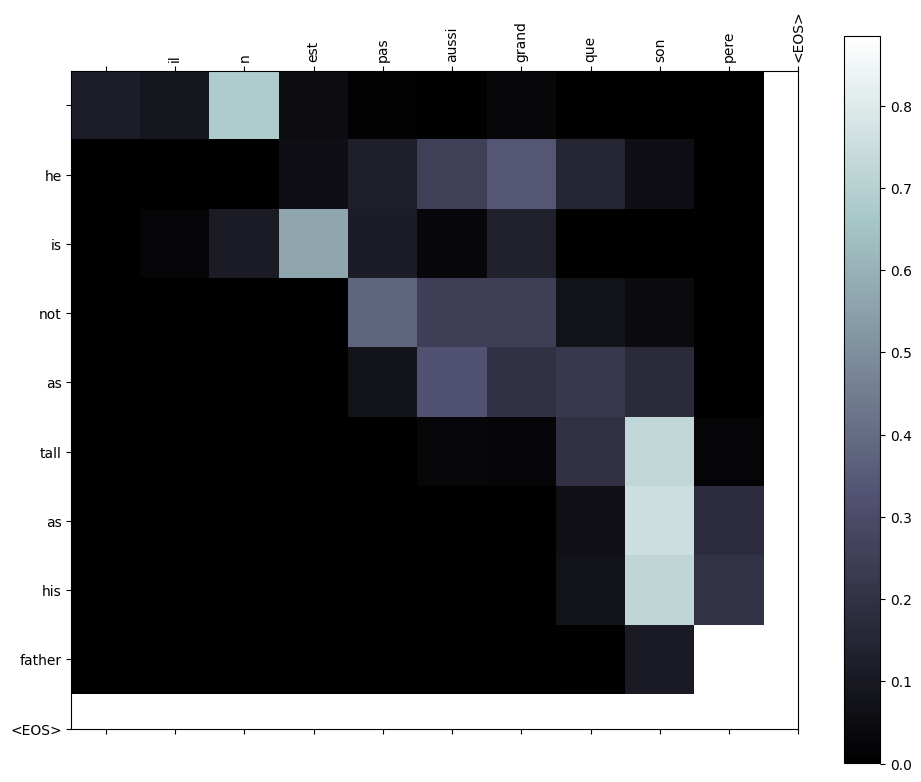

--------------------------------------------------
input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


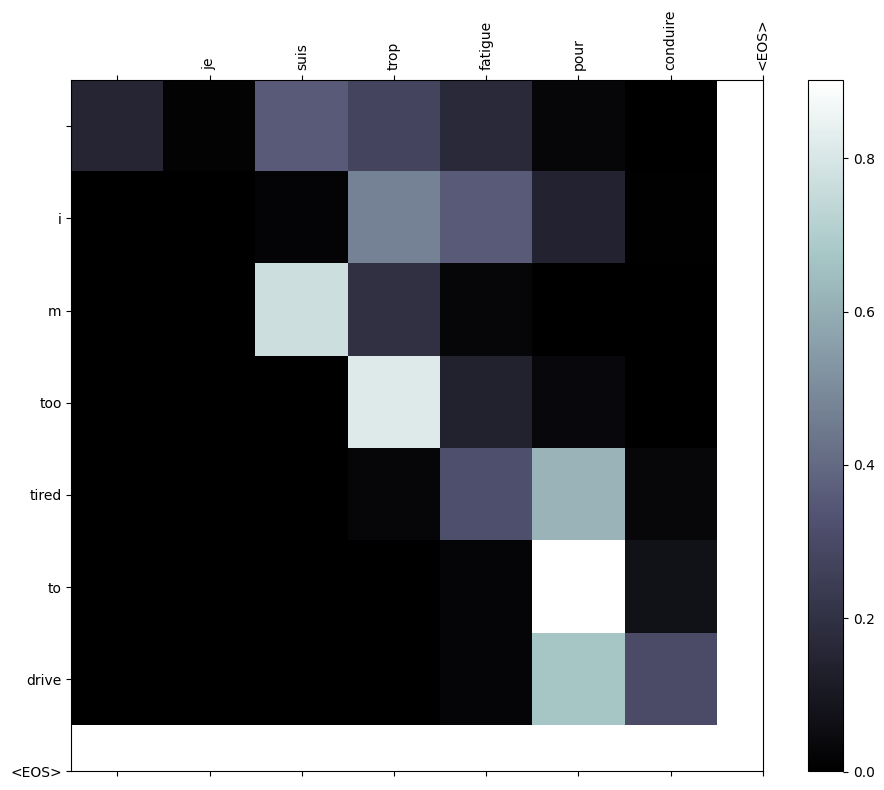

--------------------------------------------------
input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


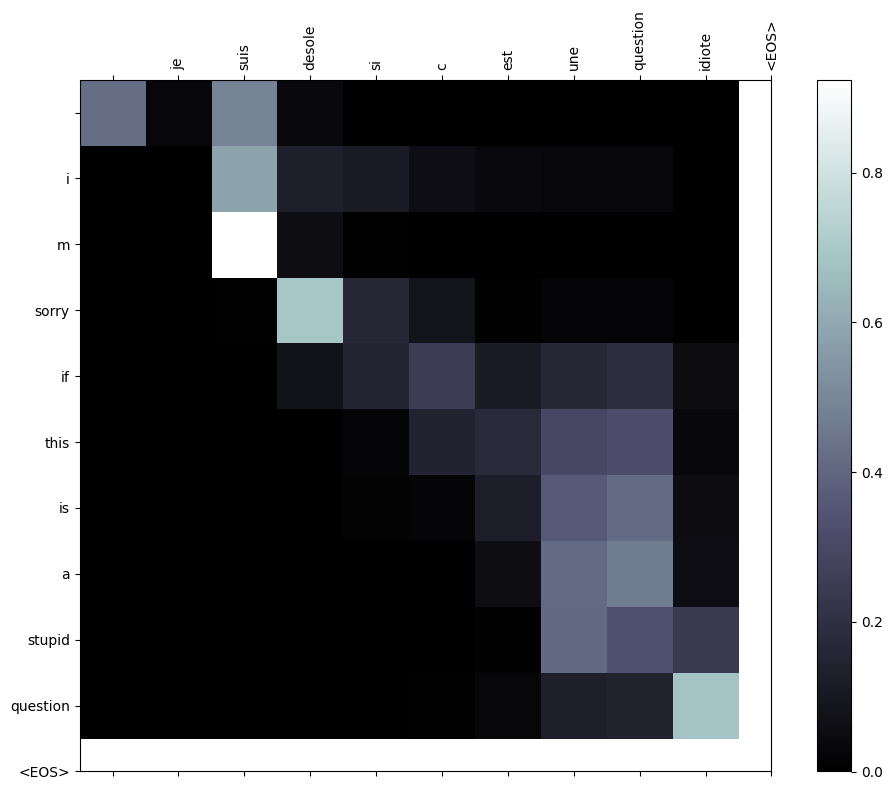

--------------------------------------------------
input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


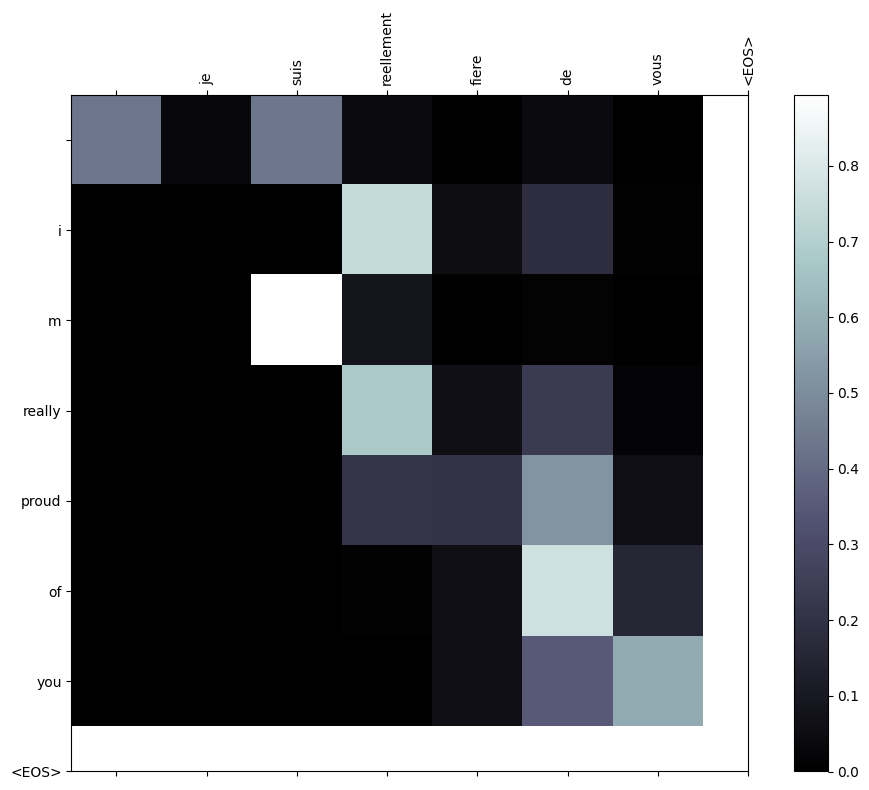

--------------------------------------------------


In [26]:
import matplotlib.pyplot as plt
from matplotlib import ticker

# Включаем интерактивный режим для Jupyter
%matplotlib inline

def showAttention(input_sentence: str, output_words: List[str], attentions: torch.Tensor) -> None:
    """Display attention weights."""
    fig: plt.Figure = plt.figure(figsize=(10, 8))
    ax: plt.Axes = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)
    
    input_words: List[str] = input_sentence.split(' ')
    
    ax.set_xticks(range(len(input_words) + 2))
    ax.set_yticks(range(len(output_words) + 1))
    
    ax.set_xticklabels([''] + input_words + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)


def evaluateAndShowAttention(input_sentence: str) -> None:
    """Evaluate and show attention for a sentence."""
    output_words: List[str]
    attentions: torch.Tensor
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    print('-' * 50)


# Закрываем все предыдущие фигуры перед запуском
plt.close('all')

evaluateAndShowAttention('il n est pas aussi grand que son pere')
evaluateAndShowAttention('je suis trop fatigue pour conduire')
evaluateAndShowAttention('je suis desole si c est une question idiote')
evaluateAndShowAttention('je suis reellement fiere de vous')